In [1]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
class SnakeExtended:
    """
    Should add in plotting and boundary condition specification methods.
    """

    def __init__(self, B=1, c=1, l=1, sigma=0.1, rho=1, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.bt = self.B / self.c
        self.sigma = sigma
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((4, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        self.y[0, 0] = np.pi / 2
        self.y[0, -1] = 0
        dy_ds = np.exp(-((self.x - 0.75) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, -self.x, initial=0) / si.trapz(dy_ds, self.x)
            + np.pi / 2
        )  # want s=0 to be at pi/2 so need to do integral backwards
        d2y_ds2 = np.gradient(dy_ds, self.x, edge_order=2)
        d3y_ds3 = np.gradient(d2y_ds2, self.x, edge_order=2)
        self.y[0, :] = y_guess
        self.y[1, :] = dy_ds
        self.y[2, :] = d2y_ds2
        self.y[3, :] = d3y_ds3

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = y[2]
        dy2_dx = y[3]
        dy3_dx = -(1 + self.bt) / (self.sigma ** 2) * y[2] + (
            self.rho * self.g * l ** 3
        ) / (self.c * self.sigma ** 2) * x * np.cos(y[0])
        dy_dx = np.vstack((dy0_dx, dy1_dx, dy2_dx, dy3_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0] - np.pi / 2
        res2 = yb[0]  # - np.pi / 2
        res3 = ya[1]
        res4 = ya[2]
        res5 = ya[3]
        residuals = np.array([res1, res2, res3, res4, res5])
        return residuals

    def solve(self, verbose=0):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l], verbose=verbose
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.x_pos -= self.x_pos[-1]
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos -= self.y_pos[-1]

    def cost(self, alpha=0.5):
        height_term = self.y_pos[0] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

In [3]:
rho = 1
l = 1
B = 1
cs = np.linspace(10.01, 1000 * B, 11)
cs_conv = []
costs = []
ls = []
xs = []
ys = []
moment_at_base = []
curve = []

for c in cs:
    snake = SnakeExtended(B=B, c=c, l=l, sigma=0.1, rho=rho, mesh_points=50)
    snake.solve()
    if snake.sol.status == 0:
        cs_conv.append(c)
        cost = snake.cost(alpha=0.9)
        costs.append(cost)
        ls.append(snake.l)
        xs.append(-snake.x_pos)  # because everything is backward. s=0 is tip.
        ys.append(-snake.y_pos)
        base_moment = -(snake.B + snake.c) / (snake.l) * snake.sol.y[1][-1]
        moment_at_base.append(base_moment)
        max_curve = -snake.sol.y[1][-1] / snake.l
        curve.append(max_curve)
        # l = snake.l
    else:
        print(f"Failed! with c = {round(c, 3)} message says {snake.sol.message}")

cs_conv = np.array(cs_conv)
curve = np.array(curve)
moment_at_base = np.array(moment_at_base)
costs = np.array(costs)
ls = np.array(ls)
max_x = np.array([x[0] for x in xs])
max_y = np.array([y[0] for y in ys])

In [4]:
def fit_linear_plot(x_data, y_data, plot_title, x_label, y_label):
    """
    Fit a line to data and plot it.
    """
    regressor = linregress(x_data, y_data)
    m, b = regressor.slope, regressor.intercept
    plt.plot(x_data, y_data, "-o", label="Simulated data")
    plt.plot(x_data, m * x_data + b, label=f"{round(m, 3)}x + {round(b, 3)}")
    plt.legend(fontsize=15)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.title(plot_title, fontsize=18)
    plt.show()
    return regressor


def fit_power_law_plot(x_data, y_data, plot_title="", x_label="", y_label=""):
    """
    Fit power law data and plot the fit.
    """
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)
    regressor = linregress(log_x_data, log_y_data)
    m, b = regressor.slope, regressor.intercept

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(plot_title, fontsize=18)

    axs[0].plot(x_data, y_data, "-o", label="Simulated data")
    axs[0].plot(x_data, np.exp(b) * x_data ** m, label=f"exponent = {round(m, 4)}")
    axs[0].set_xlabel(x_label, fontsize=18)
    axs[0].set_ylabel(y_label, fontsize=18)
    axs[0].legend()

    axs[1].loglog(x_data, y_data, "o-", label="Simulated data")
    axs[1].loglog(x_data, np.exp(b) * x_data ** m, label=f"slope = {round(m, 4)}")
    axs[1].set_xlabel("log" + x_label, fontsize=18)
    axs[1].set_ylabel("log" + y_label, fontsize=18)
    axs[1].legend()
    plt.show()

    return regressor

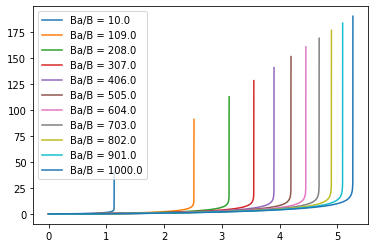

In [5]:
for i in range(cs_conv.size):
    plt.plot(xs[i], ys[i], label=f"Ba/B = {round(cs_conv[i], 0)}")
    plt.legend()

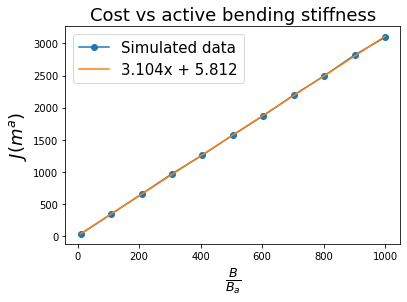

In [6]:
cost_reg = fit_linear_plot(
    cs_conv,
    costs,
    plot_title="Cost vs active bending stiffness",
    x_label=r"$\frac{B_a}{B}$",
    y_label=r"$J(m^a)$",
)

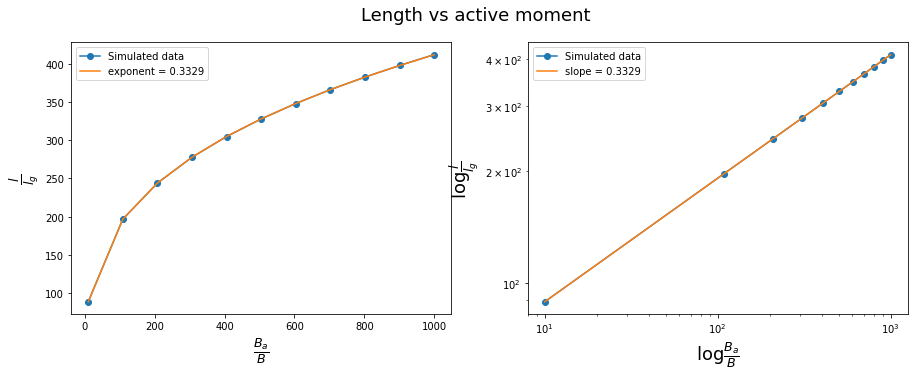

In [7]:
l_v_c_reg = fit_power_law_plot(
    cs_conv,
    ls / snake.lg,
    plot_title="Length vs active moment",
    x_label=r"$\frac{B_a}{B}$",
    y_label=r"$\frac{l}{l_g}$",
)

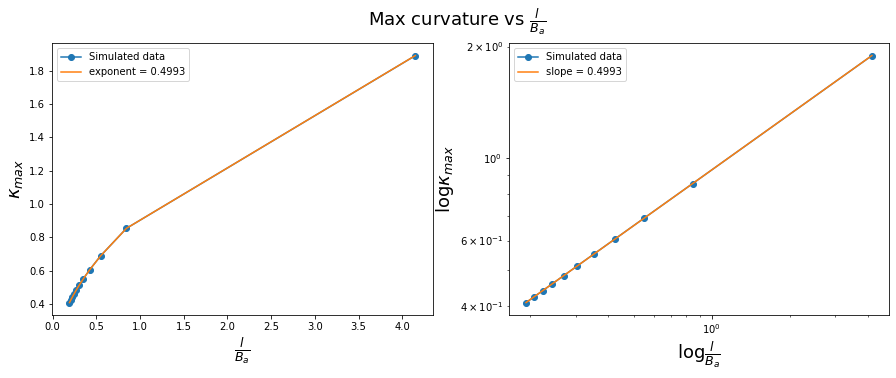

In [8]:
kap_vs_lb_reg = fit_power_law_plot(
    ls / cs_conv,
    curve,
    plot_title=r"Max curvature vs $\frac{l}{B_a}$",
    x_label=r"$\frac{l}{B_a}$",
    y_label=r"$\kappa_{max}$",
)

Another way of saying the same as max curvature scaling

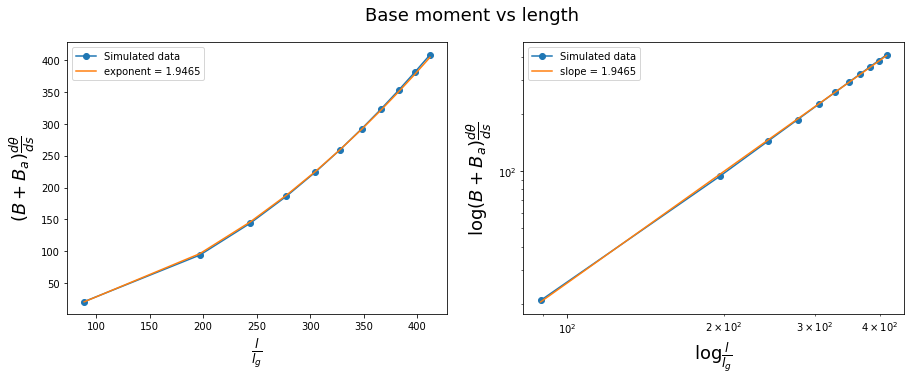

In [9]:
base_mom_vs_l = fit_power_law_plot(
    ls / snake.lg,
    moment_at_base,
    plot_title=r"Base moment vs length",
    x_label=r"$\frac{l}{l_g}$",
    y_label=r"$(B+B_a)\frac{d\theta}{ds}$",
)

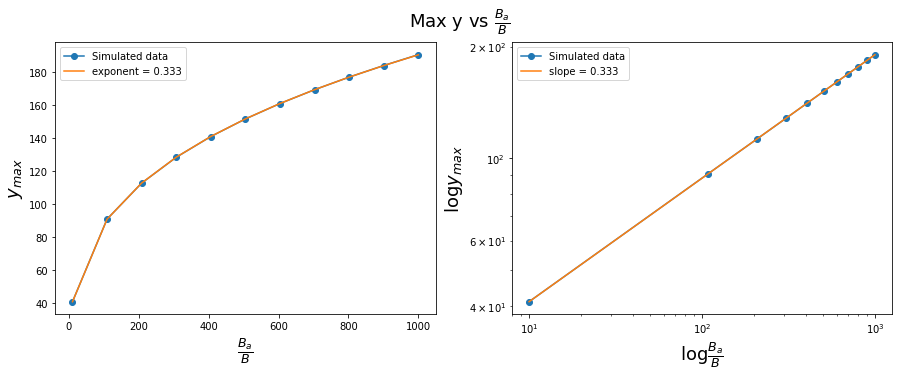

In [10]:
max_y_vs_b_reg = fit_power_law_plot(
    cs_conv / B,
    max_y,
    plot_title=r"Max y vs $\frac{B_a}{B}$",
    x_label=r"$\frac{B_a}{B}$",
    y_label=r"$y_{max}$",
)

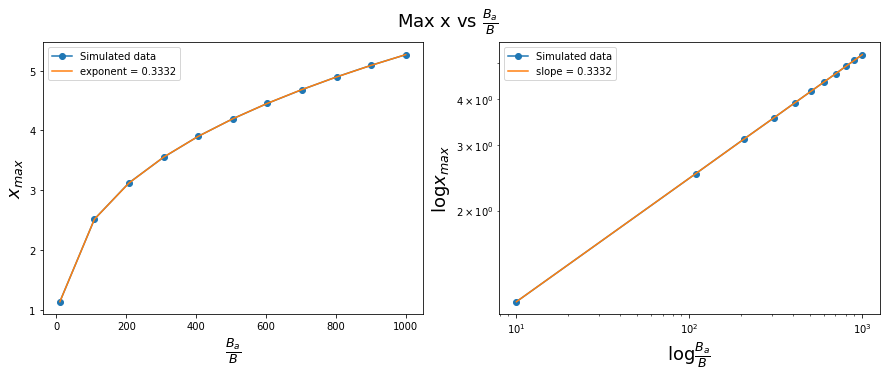

In [11]:
max_y_vs_b_reg = fit_power_law_plot(
    cs_conv / B,
    max_x,
    plot_title=r"Max x vs $\frac{B_a}{B}$",
    x_label=r"$\frac{B_a}{B}$",
    y_label=r"$x_{max}$",
)

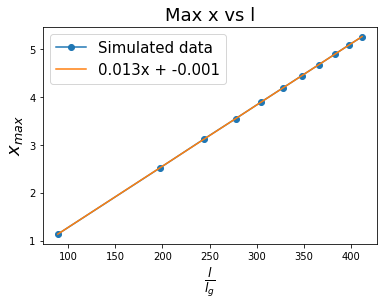

In [12]:
x_max_l_reg = fit_linear_plot(
    ls / snake.lg,
    max_x,
    plot_title="Max x vs l",
    x_label=r"$\frac{l}{l_g}$",
    y_label=r"$x_{max}$",
)

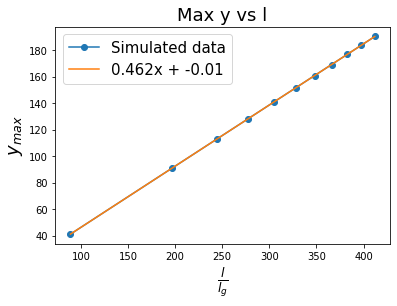

In [13]:
y_max_l_reg = fit_linear_plot(
    ls / snake.lg,
    max_y,
    plot_title="Max y vs l",
    x_label=r"$\frac{l}{l_g}$",
    y_label=r"$y_{max}$",
)

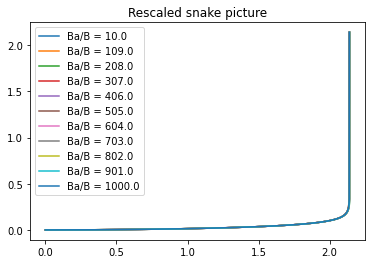

In [14]:
for i in range(cs_conv.size):
    plt.plot(
        xs[i] / (ls[i] * x_max_l_reg.slope),
        ys[i] / (ls[i] * y_max_l_reg.slope),
        label=f"Ba/B = {round(cs_conv[i], 0)}",
    )
    plt.legend()
plt.title("Rescaled snake picture")
plt.show()

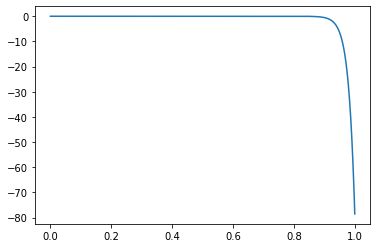

In [18]:
plt.plot(snake.sol.x, snake.sol.y[1])
plt.show()